In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dotenv import load_dotenv
import os

In [34]:
# ready the token for downloading data from Kaggle
load_dotenv()

kaggle_token = os.getenv("MY_TOKEN")

# display maximum amount of rows, especially if for things like value_counts(). 
# This is no problem, since all the outputs will be saved to text files
pd.set_option('display.max_rows', None)


# EDA/Cleaning

It is important to demonstrate the nature of data, so that it is possible to then clean it. Then, do an exploratory analysis again, so that it is possible to see it again.

The most important variables are those related to courses, students taking said courses, and the courses' prerequisites. No one dataset has all three.

In [35]:
df_prerequisites = pd.read_csv("data/uiuc-prerequisites.csv")

df_learning_analytics = pd.read_csv("data/assessments.csv")

# imports the database from the Internet. Apparently, this is the best(if not only) possible method 
# in HuggingFace
df_coursera = pd.read_csv("hf://datasets/azrai99/coursera-course-dataset/coursera_course_2024.csv", index_col="Unnamed: 0")

## Prerequisites Dataset

+ Courses - Yes
+ Courses' prerequisites - Yes
+ Students - No

This dataset has one row per course, with each course having up to 10 prerequisites possible. However, there is only one course with 9 prerequisites and no courses with 10 prerequisites. The rows "0"-"9" contain names of each of the prerequisites per course.

For example, if row has a non-empty value in "0", this means that the course of that row has at least one prerequisite. But if "PrerequisiteNumber"==0, this means that the course in question has no prerequisites.

This confusing nomenclature maybe should be fixed. Other than that, it is a very clean dataset.

Point is, a student who chooses to take any course in this list should be able to know what prerequisites that course has, and if they, themselves, already fit the prerequisites by having taken the prerequisite courses. But this database has no students, and the other database that does have students cannot be merged to this one in any way

### Initial EDA

In [36]:
df_prerequisites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8589 entries, 0 to 8588
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Course              8589 non-null   object 
 1   PrerequisiteNumber  8589 non-null   int64  
 2   0                   3426 non-null   object 
 3   1                   1574 non-null   object 
 4   2                   673 non-null    object 
 5   3                   287 non-null    object 
 6   4                   111 non-null    object 
 7   5                   54 non-null     object 
 8   6                   36 non-null     object 
 9   7                   16 non-null     object 
 10  8                   1 non-null      object 
 11  9                   0 non-null      float64
dtypes: float64(1), int64(1), object(10)
memory usage: 805.3+ KB


In [37]:
df_prerequisites_courses = df_prerequisites["Course"].value_counts(dropna=False)

with open("data/illinois_prerequisite_courses.txt", "w") as f:
  print(df_prerequisites_courses, file=f)




In [38]:
df_prerequisite_number_count = df_prerequisites["PrerequisiteNumber"].value_counts(dropna=False)

This bar plot shows the distribution of course prerequisite numbers. Over 5000 courses have no prerequisites, and only slightly fewer than 2000 courses have 1 prerequisite. 

This quantity seems to follow the power law of distribution.

Text(0.5, 0, '# of prerequisites for course')

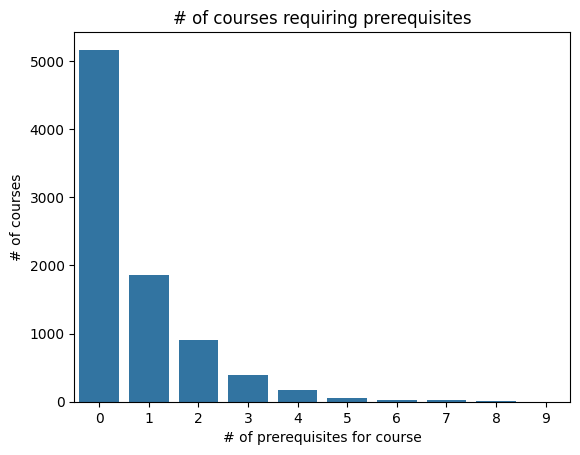

In [39]:
sns.barplot(data=df_prerequisite_number_count)
plt.title("# of courses requiring prerequisites")
plt.ylabel("# of courses")
plt.xlabel("# of prerequisites for course")

In [40]:
df_prerequisites["0"].value_counts(dropna=False)

0
NaN         5163
PSYC 100      46
ECON 302      35
MATH 241      33
MATH 220      32
MATH 285      30
PS 101        29
CS 225        27
CS 101        25
PS 240        25
IB 150        25
CHEM 102      24
SOC 100       23
PSYC 210      18
FIN 300       18
AFRO 100      18
CHEM 104      18
STAT 410      17
SPAN 228      16
ARCH 210      15
CHEM 232      15
MSE 401       15
ECE 310       15
ECON 202      15
CS 241        15
MCB 252       14
MUS 240       14
IB 203        14
MATH 225      14
LING 100      14
AAS 100       14
ECON 102      13
MCB 250       13
PS 280        13
ANTH 220      13
MATH 415      13
FR 207        13
ECE 329       13
AE 311        13
SOCW 400      13
NRES 201      12
TAM 251       12
MCB 150       12
STAT 400      12
BADM 320      11
GWS 100       11
FIN 520       11
HDFS 105      11
MCB 450       11
ECE 313       11
ANTH 102      10
ECE 340       10
ANTH 103      10
CEE 471       10
MATH 112      10
CEE 310       10
PSYC 407      10
PHYS 212      10
ANTH 230    

In [41]:
df_prerequisites.head()

,Course,PrerequisiteNumber,0,1,2,3,4,5,6,7,8,9
0,AAS 100,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAS 105,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAS 120,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAS 199,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAS 200,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This is how it looks like, when a course has 9 prerequisites, the highest possible number in this dataset.

In [42]:
df_prerequisites[df_prerequisites["PrerequisiteNumber"]==9]

,Course,PrerequisiteNumber,0,1,2,3,4,5,6,7,8,9
677,ANSC 498,9,ANSC 293,ANSC 294,ANSC 295,ANSC 299,ANSC 396,ANSC 398,ACES 293,ACES 298,ACES 299,NaN


### Cleaning
This dataset is already quite clean, but I will add a few QoL changes to make it more usable.
1. Drop column "9", since it has no values at all
2. Rename remaining columns "0"-"8"

In [43]:
df_prerequisites_v1 = df_prerequisites.copy()
df_prerequisites_v1 = df_prerequisites_v1.drop("9", axis=1)

In [44]:
df_prerequisites_v2 = df_prerequisites_v1.copy()

rename_dictionary = {
    "0": "1st prerequisite",
    "1": "2nd prerequisite",
    "2": "3rd prerequisite",
    "3": "4th prerequisite",
    "4": "5th prerequisite",
    "5": "6th prerequisite",
    "6": "7th prerequisite",
    "7": "8th prerequisite",
    "8": "9th prerequisite"
}

df_prerequisites_v2 = df_prerequisites_v2.rename(mapper=rename_dictionary, axis=1)
df_prerequisites_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8589 entries, 0 to 8588
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Course              8589 non-null   object
 1   PrerequisiteNumber  8589 non-null   int64 
 2   1st prerequisite    3426 non-null   object
 3   2nd prerequisite    1574 non-null   object
 4   3rd prerequisite    673 non-null    object
 5   4th prerequisite    287 non-null    object
 6   5th prerequisite    111 non-null    object
 7   6th prerequisite    54 non-null     object
 8   7th prerequisite    36 non-null     object
 9   8th prerequisite    16 non-null     object
 10  9th prerequisite    1 non-null      object
dtypes: int64(1), object(10)
memory usage: 738.2+ KB


### Learning Analytics



No idea how to connect this one to the first one. In fact, this is a composition of several databases, and I do not know, which ones are the most useful, if any are at all.

However, the "students"-related datasets could be most useful, as students are a useful component of the web app's workings, and no other database in this code has information on individual students.

In [45]:
df_learning_analytics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


In [46]:
df_learning_analytics_code_module = df_learning_analytics["code_module"].value_counts(dropna=False).sort_index()

Text(0.5, 0, 'Code module')

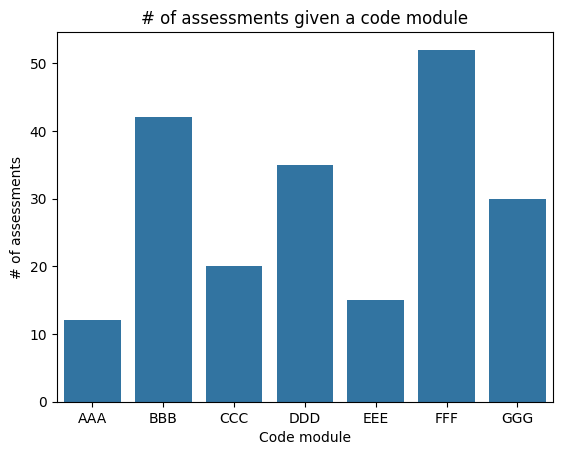

In [47]:
sns.barplot(data=df_learning_analytics_code_module)
plt.title("# of assessments given a code module")
plt.ylabel("# of assessments")
plt.xlabel("Code module")

In [48]:
df_learning_analytics["code_presentation"].value_counts(dropna=False)

code_presentation
2014J    57
2014B    57
2013J    53
2013B    39
Name: count, dtype: int64

In [49]:
df_learning_analytics["id_assessment"].value_counts(dropna=False)

id_assessment
1752     1
1753     1
1754     1
1755     1
1756     1
1757     1
1758     1
1759     1
1760     1
1761     1
1762     1
1763     1
14991    1
14992    1
14993    1
14994    1
14995    1
14984    1
14985    1
14986    1
14987    1
14988    1
14989    1
14990    1
15003    1
15004    1
15005    1
15006    1
15007    1
14996    1
14997    1
14998    1
14999    1
15000    1
15001    1
15002    1
15015    1
15016    1
15017    1
15018    1
15019    1
15008    1
15009    1
15010    1
15011    1
15012    1
15013    1
15014    1
15020    1
15021    1
15022    1
15023    1
15024    1
15025    1
24286    1
24287    1
24288    1
24289    1
24282    1
24283    1
24284    1
24285    1
24290    1
40087    1
24295    1
24296    1
24297    1
24298    1
24291    1
24292    1
24293    1
24294    1
24299    1
40088    1
25341    1
25342    1
25343    1
25344    1
25345    1
25346    1
25347    1
25334    1
25335    1
25336    1
25337    1
25338    1
25339    1
25340    1
25348    1
25349  

A few assignments don't have dates. This is inconvenient. How to solve it?

In [50]:
df_learning_analytics["date"].value_counts(dropna=False)

date
222.0    15
229.0    14
NaN      11
241.0     9
227.0     8
236.0     8
166.0     7
19.0      7
117.0     6
47.0      5
54.0      5
124.0     5
131.0     5
152.0     4
159.0     3
61.0      3
68.0      3
89.0      3
96.0      3
53.0      3
25.0      3
33.0      3
207.0     3
200.0     3
173.0     3
187.0     2
215.0     2
32.0      2
18.0      2
67.0      2
52.0      2
116.0     2
235.0     2
24.0      2
82.0      2
151.0     2
194.0     2
208.0     2
158.0     2
102.0     1
137.0     1
201.0     1
40.0      1
81.0      1
206.0     1
149.0     1
170.0     1
114.0     1
79.0      1
23.0      1
51.0      1
144.0     1
214.0     1
109.0     1
12.0      1
110.0     1
123.0     1
88.0      1
165.0     1
146.0     1
195.0     1
62.0      1
111.0     1
41.0      1
20.0      1
261.0     1
74.0      1
240.0     1
228.0     1
87.0      1
129.0     1
94.0      1
171.0     1
199.0     1
136.0     1
Name: count, dtype: int64

### Coursera Dataset

+ Courses - Yes
+ Courses' prerequisites - Partly
+ Students - No

In [51]:
df_coursera.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6645 entries, 0 to 6644
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              6645 non-null   object 
 1   enrolled           6645 non-null   object 
 2   rating             6645 non-null   object 
 3   num_reviews        5253 non-null   float64
 4   Instructor         6644 non-null   object 
 5   Organization       6645 non-null   object 
 6   Skills             6645 non-null   object 
 7   Description        6635 non-null   object 
 8   Modules/Courses    6635 non-null   object 
 9   Level              5867 non-null   object 
 10  Schedule           4757 non-null   object 
 11  URL                6645 non-null   object 
 12  Satisfaction Rate  2198 non-null   object 
dtypes: float64(1), object(12)
memory usage: 726.8+ KB


This column represents the courses themselves.

In [52]:
df_coursera["title"].value_counts(dropna=False)

title
Introduction to Generative AI                                                                                                    3
Machine Learning Specialization                                                                                                  2
Business Analytics Specialization                                                                                                2
Systems and Application Security                                                                                                 2
Linux Fundamentals                                                                                                               2
Market Research Specialization                                                                                                   2
Data Governance with Databricks                                                                                                  2
GenAI for Everyone                                                           

"Enrolled" shows numbers of students enrolled to a course, rather than individual students' IDs. This makes things inconvenient.

In [53]:
df_coursera["enrolled"].value_counts(dropna=False)

enrolled
Enrollment number not found    1758
2,870                             3
1,974                             3
2,133                             3
3,413                             3
6,409                             3
3,970                             3
3,488                             3
1,722                             3
2,227                             3
2,829                             3
1,592                             3
16,104                            3
2,479                             3
3,355                             3
5,339                             3
2,368                             2
1,949                             2
5,407                             2
7,768                             2
3,568                             2
36,885                            2
18,219                            2
2,437                             2
8,866                             2
6,780                             2
3,123                             2
5,014              

In [54]:
df_coursera["Instructor"].value_counts(dropna=False)

Instructor
Google Cloud Training                                                 197
Microsoft                                                             159
Packt - Course Instructors                                            145
Subject Matter Expert                                                 114
IBM Skills Network Team                                                85
Google Career Certificates                                             68
AWS Instructor                                                         51
LearnKartS                                                             49
Taught by Meta Staff                                                   45
Whizlabs Instructor                                                    42
Skill-Up EdTech Team                                                   42
Board Infinity                                                         41
EDUCBA                                                                 40
CareerCatalyst             

"Skills" is a series of lists. And that is no good, since if we want to use this data, we want to have one skill per cell. However, I do not know how we will use this data, if at all.

"Skills" actually represent the prerequisite courses, because at least some skills(i.e. "Artificial Intelligence (AI)") correspond to courses that can be taken(i.e. "Introduction to Generative AI").
But how to make a skill correspond?

In [55]:
df_coursera["Skills"].value_counts(dropna=False)

Skills
[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                1954
['Artificial Intelligence (AI)', 'Data Science', 'Python Programming', 'Information Engineering', 'Machine Learning']                                                                                                                                                                                                                                                                                                                                                                7
['English Grammar', 'Reading Comprehension', 'Busin

In [56]:
df_coursera["num_reviews"].value_counts(dropna=False)

num_reviews
NaN         1392
12.0          71
10.0          70
14.0          64
11.0          59
15.0          58
13.0          53
16.0          53
23.0          48
21.0          46
20.0          40
19.0          39
30.0          36
25.0          35
27.0          35
17.0          35
22.0          32
1.0           32
24.0          31
34.0          28
18.0          28
29.0          28
32.0          27
47.0          27
28.0          26
53.0          25
54.0          25
39.0          25
37.0          25
49.0          24
33.0          24
26.0          24
31.0          24
44.0          23
41.0          23
51.0          23
36.0          22
43.0          22
35.0          21
50.0          20
65.0          20
38.0          18
57.0          18
6.0           17
103.0         17
59.0          17
64.0          17
46.0          16
52.0          16
82.0          16
40.0          15
45.0          15
73.0          15
66.0          14
67.0          14
83.0          14
97.0          14
75.0          13
80

In [57]:
df_coursera_v1 = df_coursera.drop_duplicates()
df_coursera_v1.loc[df_coursera_v1["enrolled"] == "Enrollment number not found", "enrolled"] = pd.NA
df_coursera_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6645 entries, 0 to 6644
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              6645 non-null   object 
 1   enrolled           4887 non-null   object 
 2   rating             6645 non-null   object 
 3   num_reviews        5253 non-null   float64
 4   Instructor         6644 non-null   object 
 5   Organization       6645 non-null   object 
 6   Skills             6645 non-null   object 
 7   Description        6635 non-null   object 
 8   Modules/Courses    6635 non-null   object 
 9   Level              5867 non-null   object 
 10  Schedule           4757 non-null   object 
 11  URL                6645 non-null   object 
 12  Satisfaction Rate  2198 non-null   object 
dtypes: float64(1), object(12)
memory usage: 726.8+ KB
